<a href="https://colab.research.google.com/github/fralfaro/r4ds-book/blob/main/docs/18_pipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipes

## Introduction

Pipes are a powerful tool for clearly expressing a sequence of multiple operations. So far, you've been using them without knowing how they work, or what the alternatives are. Now, in this chapter, it's time to explore the pipe in more detail. You'll learn the alternatives to the pipe, when you shouldn't use the pipe, and some useful related tools.

### Prerequisites

The pipe, `%>%`, comes from the __magrittr__ package by Stefan Milton Bache. Packages in the tidyverse load `%>%` for you automatically, so you don't usually load magrittr explicitly.  Here, however, we're focussing on piping, and we aren't loading any other packages, so we will load it explicitly.



In [1]:
library(magrittr)


## Piping alternatives

The point of the pipe is to help you write code in a way that easier to read and understand. To see why the pipe is so useful, we're going to explore a number of ways of writing the same code. Let's use code to tell a story about a little bunny named Foo Foo:

> Little bunny Foo Foo  
> Went hopping through the forest  
> Scooping up the field mice  
> And bopping them on the head  

This is a popular Children's poem that is accompanied by hand actions.

We'll start by defining an object to represent little bunny Foo Foo:



```r
foo_foo <- little_bunny()
```



And we'll use a function for each key verb: `hop()`, `scoop()`, and `bop()`. Using this object and these verbs, there are (at least) four ways we could retell the story in code:

1. Save each intermediate step as a new object.
1. Overwrite the original object many times.
1. Compose functions.
1. Use the pipe.

We'll work through each approach, showing you the code and talking about the advantages and disadvantages.

### Intermediate steps

The simplest approach is to save each step as a new object:



```r
foo_foo_1 <- hop(foo_foo, through = forest)
foo_foo_2 <- scoop(foo_foo_1, up = field_mice)
foo_foo_3 <- bop(foo_foo_2, on = head)
```



The main downside of this form is that it forces you to name each intermediate element. If there are natural names, this is a good idea, and you should do it. But many times, like this in this example, there aren't natural names, and you add numeric suffixes to make the names unique. That leads to two problems:

1. The code is cluttered with unimportant names

1. You have to carefully increment the suffix on each line. 

Whenever I write code like this, I invariably use the wrong number on one line and then spend 10 minutes scratching my head and trying to figure out what went wrong with my code.

You may also worry that this form creates many copies of your data and takes up a lot of memory. Surprisingly, that's not the case. First, note that proactively worrying about memory is not a useful way to spend your time: worry about it when it becomes a problem (i.e. you run out of memory), not before. Second, R isn't stupid, and it will share columns across data frames, where possible. Let's take a look at an actual data manipulation pipeline where we add a new column to `ggplot2::diamonds`:


In [3]:
install.packages("pryr")
library(pryr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘lobstr’




In [4]:
diamonds <- ggplot2::diamonds
diamonds2 <- diamonds %>% 
  dplyr::mutate(price_per_carat = price / carat)

pryr::object_size(diamonds)
pryr::object_size(diamonds2)
pryr::object_size(diamonds, diamonds2)

3.46 MB

3.89 MB

3.89 MB


`pryr::object_size()` gives the memory occupied by all of its arguments. The results seem counterintuitive at first:

* `diamonds` takes up 3.46 MB,
* `diamonds2` takes up 3.89 MB,
* `diamonds` and `diamonds2` together take up 3.89 MB!

How can that work? Well, `diamonds2` has 10 columns in common with `diamonds`: there's no need to duplicate all that data, so the two data frames have variables in common. These variables will only get copied if you modify one of them. In the following example, we modify a single value in `diamonds$carat`. That means the `carat` variable can no longer be shared between the two data frames, and a copy must be made. The size of each data frame is unchanged, but the collective size increases:


In [5]:
diamonds$carat[1] <- NA
pryr::object_size(diamonds)
pryr::object_size(diamonds2)
pryr::object_size(diamonds, diamonds2)

3.46 MB

3.89 MB

4.32 MB


(Note that we use `pryr::object_size()` here, not the built-in `object.size()`. `object.size()` only takes a single object so it can't compute how data is shared across multiple objects.)

### Overwrite the original

Instead of creating intermediate objects at each step, we could overwrite the original object:



```r
foo_foo <- hop(foo_foo, through = forest)
foo_foo <- scoop(foo_foo, up = field_mice)
foo_foo <- bop(foo_foo, on = head)
```



This is less typing (and less thinking), so you're less likely to make mistakes. However, there are two problems:

1.  Debugging is painful: if you make a mistake you'll need to re-run the 
    complete pipeline from the beginning.
    
1.  The repetition of the object being transformed (we've written `foo_foo` six 
    times!) obscures what's changing on each line. 

### Function composition

Another approach is to abandon assignment and just string the function calls together:



```r
bop(
  scoop(
    hop(foo_foo, through = forest),
    up = field_mice
  ), 
  on = head
)
```



Here the disadvantage is that you have to read from inside-out, from right-to-left, and that the arguments end up spread far apart (evocatively called the 
[dagwood sandwhich](https://en.wikipedia.org/wiki/Dagwood_sandwich) problem). In short, this code is hard for a human to consume.

### Use the pipe 

Finally, we can use the pipe:



```r
foo_foo %>%
  hop(through = forest) %>%
  scoop(up = field_mice) %>%
  bop(on = head)
```



This is my favourite form, because it focusses on verbs, not nouns. You can read this series of function compositions like it's a set of imperative actions. Foo Foo hops, then scoops, then bops. The downside, of course, is that you need to be familiar with the pipe. If you've never seen `%>%` before, you'll have no idea what this code does. Fortunately, most people pick up the idea very quickly, so when you share you code with others who aren't familiar with the pipe, you can easily teach them.

The pipe works by performing a "lexical transformation": behind the scenes, magrittr reassembles the code in the pipe to a form that works by overwriting an intermediate object. When you run a pipe like the one above, magrittr does something like this:




```r
my_pipe <- function(.) {
  . <- hop(., through = forest)
  . <- scoop(., up = field_mice)
  bop(., on = head)
}
my_pipe(foo_foo)
```



This means that the pipe won't work for two classes of functions:

1.  Functions that use the current environment. For example, `assign()`
    will create a new variable with the given name in the current environment:


In [6]:
assign("x", 10)
x

[1] 10

In [7]:
"x" %>% assign(100)
x

[1] 10

 
  The use of assign with the pipe does not work because it assigns it to 
    a temporary environment used by `%>%`. If you do want to use assign with the
    pipe, you must be explicit about the environment:
  

In [8]:
env <- environment()
"x" %>% assign(100, envir = env)
x

[1] 100

  
  Other functions with this problem include `get()` and `load()`.

2.  Functions that use lazy evaluation. In R, function arguments
    are only computed when the function uses them, not prior to calling the 
    function. The pipe computes each element in turn, so you can't 
    rely on this behaviour.
    
    One place that this is a problem is `tryCatch()`, which lets you capture
    and handle errors:
 

   
    ```r
    tryCatch(stop("!"), error = function(e) "An error")
    #> [1] "An error"

    stop("!") %>% 
     tryCatch(error = function(e) "An error")
    #> Error in eval(lhs, parent, parent): !
    ```
   

 
  There are a relatively wide class of functions with this behaviour,
  including `try()`, `suppressMessages()`, and `suppressWarnings()`
  in base R.
  
## When not to use the pipe

The pipe is a powerful tool, but it's not the only tool at your disposal, and it doesn't solve every problem! Pipes are most useful for rewriting a fairly short linear sequence of operations. I think you should reach for another tool when:

* Your pipes are longer than (say) ten steps. In that case, create 
  intermediate objects with meaningful names. That will make debugging easier,
  because you can more easily check the intermediate results, and it makes
  it easier to understand your code, because the variable names can help 
  communicate intent.
  
* You have multiple inputs or outputs. If there isn't one primary object
  being transformed, but two or more objects being combined together,
  don't use the pipe.

* You are starting to think about a directed graph with a complex
  dependency structure. Pipes are fundamentally linear and expressing 
  complex relationships with them will typically yield confusing code.

## Other tools from magrittr

All packages in the tidyverse automatically make `%>%` available for you, so you don't normally load magrittr explicitly. However, there are some other useful tools inside magrittr that you might want to try out:

*   When working with more complex pipes, it's sometimes useful to call a 
    function for its side-effects. Maybe you want to print out the current 
    object, or plot it, or save it to disk. Many times, such functions don't 
    return anything, effectively terminating the pipe.
    
    To work around this problem, you can use the "tee" pipe. `%T>%` works like 
    `%>%` except that it returns the left-hand side instead of the right-hand 
    side. It's called "tee" because it's like a literal T-shaped pipe.


 NULL


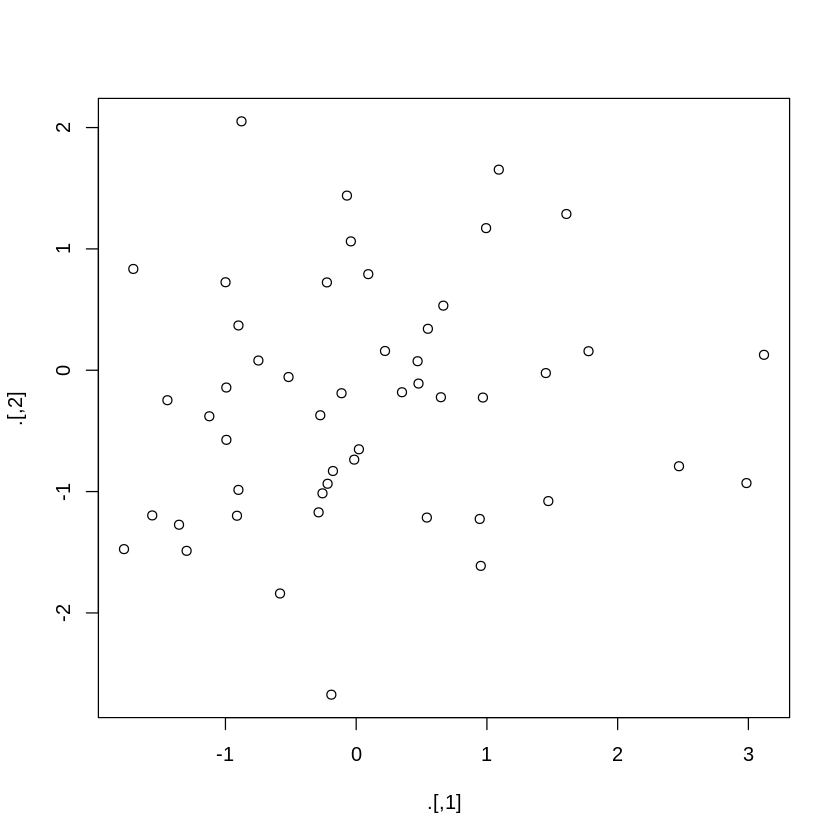

 num [1:50, 1:2] -1.575 -0.798 1.907 -0.318 -0.322 ...


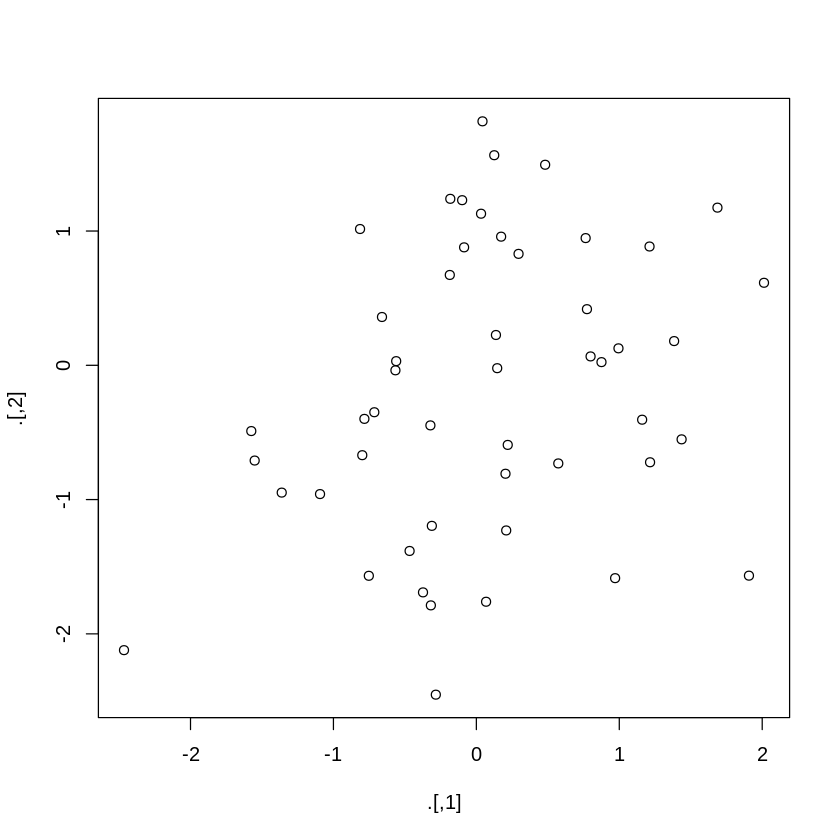

In [9]:
rnorm(100) %>%
  matrix(ncol = 2) %>%
  plot() %>%
  str()

rnorm(100) %>%
  matrix(ncol = 2) %T>%
  plot() %>%
  str()


*   If you're working with functions that don't have a data frame based API  
    (i.e. you pass them individual vectors, not a data frame and expressions 
    to be evaluated in the context of that data frame), you might find `%$%` 
    useful. It "explodes" out the variables in a data frame so that you can 
    refer to them explicitly. This is useful when working with many functions 
    in base R:
    

In [10]:
mtcars %$%
  cor(disp, mpg)

[1] -0.8475514


*   For assignment magrittr provides the `%<>%` operator which allows you to
    replace code like:
  

In [11]:
mtcars <- mtcars %>% 
  transform(cyl = cyl * 2)

 
  with
   

In [12]:
mtcars %<>% transform(cyl = cyl * 2)


  I'm not a fan of this operator because I think assignment is such a 
  special operation that it should always be clear when it's occurring.
  In my opinion, a little bit of duplication (i.e. repeating the 
  name of the object twice) is fine in return for making assignment
  more explicit.
